In [1]:
#!pip install numpy matplotlib tensorflow

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import boston_housing
from keras import models, layers

In [4]:
# Data preprocessing
def load_and_preprocess_data():
    (train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
    # Normalize data using training set statistics
    mean = train_data.mean(axis=0)
    std = train_data.std(axis=0)
    train_data = (train_data - mean) / std
    test_data = (test_data - mean) / std
    
    return train_data, train_targets, test_data, test_targets

# Execute and load into memory
train_data, train_targets, test_data, test_targets = load_and_preprocess_data()

In [7]:
print("Sample training data (first 5 rows):")
print(train_data[:5])

print("\nCorresponding training targets:")
print(train_targets[:5])


Sample training data (first 5 rows):
[[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
   0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
   0.8252202 ]
 [-0.40342651  2.99178419 -1.33391162 -0.25683275 -1.21518188  1.89434613
  -1.91036058  1.24758524 -0.85646254 -0.34843254 -1.71818909  0.43190599
  -1.32920239]
 [ 0.1249402  -0.48361547  1.0283258  -0.25683275  0.62864202 -1.82968811
   1.11048828 -1.18743907  1.67588577  1.5652875   0.78447637  0.22061726
  -1.30850006]
 [-0.40149354 -0.48361547 -0.86940196 -0.25683275 -0.3615597  -0.3245576
  -1.23667187  1.10717989 -0.51114231 -1.094663    0.78447637  0.44807713
  -0.65292624]
 [-0.0056343  -0.48361547  1.0283258  -0.25683275  1.32861221  0.15364225
   0.69480801 -0.57857203  1.67588577  1.5652875   0.78447637  0.3898823
   0.26349695]]

Corresponding training targets:
[15.2 42.3 50.  21.1 17.7]


In [9]:
print("Train data shape:", train_data.shape)
print("Train targets shape:", train_targets.shape)
print("Test data shape:", test_data.shape)
print("Test targets shape:", test_targets.shape)


Train data shape: (404, 13)
Train targets shape: (404,)
Test data shape: (102, 13)
Test targets shape: (102,)


In [11]:
from keras import Input

def build_model(input_shape):
    model = models.Sequential()
    model.add(Input(shape=(input_shape,)))  # <-- preferred way
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


In [13]:
# Load and preparain_targets, test_data, test_targets = load_and_preprocess_data()
input_shape = train_data.shape[1]


# K-Fold Cross-Validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

print("Starting K-Fold Cross-Validation...")
for fold in range(k):
    print(f"Processing fold #{fold + 1}")
    
    # Validation data from current fold
    val_data = train_data[fold * num_val_samples: (fold + 1) * num_val_samples]
    val_targets = train_targets[fold * num_val_samples: (fold + 1) * num_val_samples]
    
    # Training data from other folds
    partial_train_data = np.concatenate(
        [train_data[:fold * num_val_samples],
         train_data[(fold + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:fold * num_val_samples],
         train_targets[(fold + 1) * num_val_samples:]],
        axis=0
    )
    
    # Build and train model
    model = build_model(input_shape)
    history = model.fit(
        partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=1, verbose=0
    )
    
    # Store validation MAE
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Starting K-Fold Cross-Validation...
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [14]:
# Calculate average MAE across folds
average_mae_history = [
    np.mean([x[epoch] for x in all_mae_histories]) 
    for epoch in range(num_epochs)
]

In [15]:
# Smooth MAE values for visualization
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])  # Skip first 10 epochs

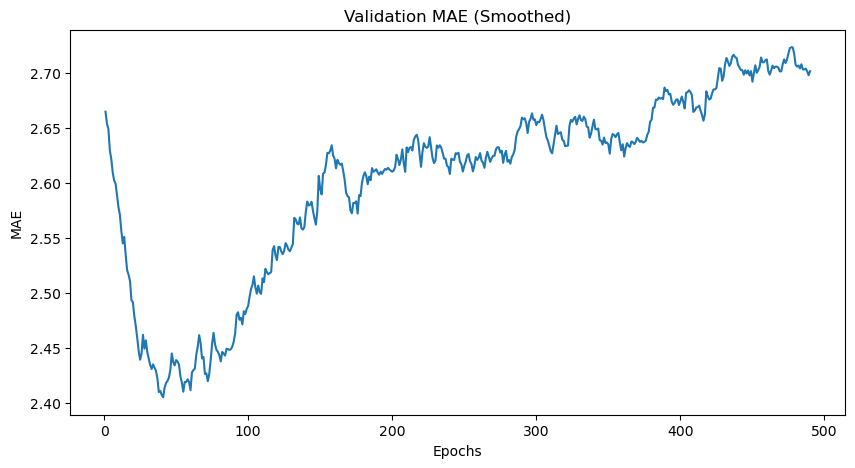

In [16]:

# Plot validation MAE
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.title('Validation MAE (Smoothed)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()


In [17]:
# Final model training with optimal epochs (determined from plot)
optimal_epochs = 80  # Identified from smoothed MAE plot
print(f"\nTraining final model for {optimal_epochs} epochs...")
final_model = build_model(input_shape)
final_model.fit(train_data, train_targets, epochs=optimal_epochs, batch_size=16, verbose=0)


Training final model for 80 epochs...


In [18]:
# Model evaluation
test_mse, test_mae = final_model.evaluate(test_data, test_targets, verbose=0)
print(f"\nTest MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")



Test MSE: 16.42
Test MAE: 2.58


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


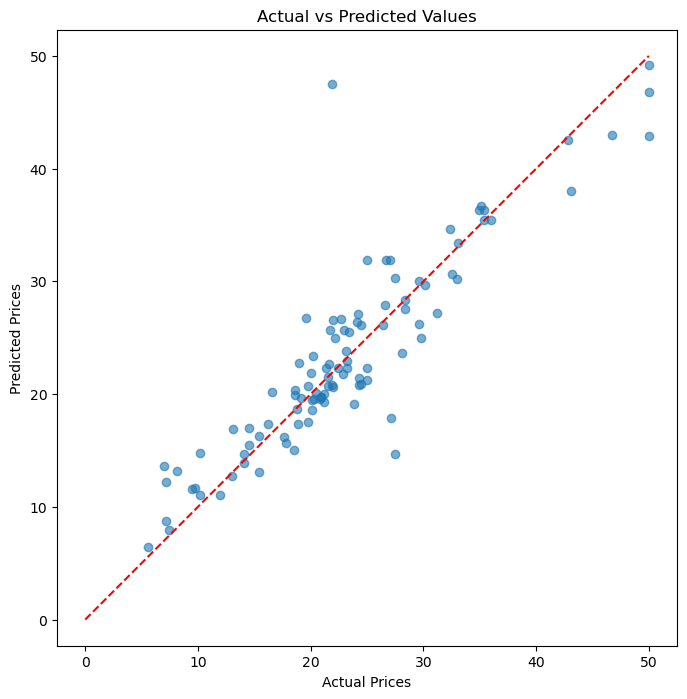

In [19]:
# Prediction visualization
predictions = final_model.predict(test_data).flatten()
plt.figure(figsize=(8, 8))
plt.scatter(test_targets, predictions, alpha=0.6)
plt.plot([0, 50], [0, 50], 'r--')  # Reference line
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.axis('equal')
plt.show()

In [20]:
# Save model
final_model.save('boston_housing_model.keras')
print("\nModel saved as boston_housing_model.keras")


Model saved as boston_housing_model.keras
